### Классификация вакансий

#### Описание задачи

Мы владельцы специфического Job-сайта и нам дали большой датасет вакансий. Одни вакансии нам интересны по своей тематике, другие не интересны (target 1 и 0 соответственно). Часть вакансий была размечена людскими ресурсами.

Ваша задача обучить классификатор, который на основе размеченной выборки умеет определять интересные вакансии для нашего сайта.

* Метрика качества ROC_AUC.
* ИСПОЛЬЗОВАТЬ ВНЕШНИЕ ДАННЫЕ С JOB-сайтов = ЗАПРЕЩЕНО
* ИСПОЛЬЗОВАТЬ другие ВНЕШНИЕ ДАННЫЕ = только с разрешения организатора (смотри Discussion)
* Результат засчитывается только при наличие кода, который этот результат повторяет
* Участие индивидуальное

#### Описание данных
* train.csv - данные для обучения
* test.csv - данные для подготовки самбита и проверки
* sampleSubmission.csv - пример корректного но бесполезного сабмита
* other.csv - необязательные данные для доп.статистик и прочих извращений (например обучение word2vec-а)

#### Описание полей
* id - внутренний идетификатор
* name - название вакансии
* description - текст вакансии
* target - класс заинтересованности

Kaggle: https://www.kaggle.com/c/text-competition-sf-ml-mlo-06

### 1. Обработка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [36]:
df_train = pd.read_csv('train.csv', delimiter='\t')
df_test = pd.read_csv('test.csv', delimiter='\t')

print(df_train.info(), '\n')
print(df_test.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
id             200000 non-null int64
name           200000 non-null object
description    200000 non-null object
target         200000 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.1+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170179 entries, 0 to 170178
Data columns (total 3 columns):
id             170179 non-null int64
name           170179 non-null object
description    170179 non-null object
dtypes: int64(1), object(2)
memory usage: 3.9+ MB
None 



In [37]:
def printHead(df, count):
    for i in range(0, count):
        for j in df.columns:
            print(j.upper(), ':', df[j][i])
        print('\n')

printHead(df_train, 1)

ID : 0
NAME : Заведующий отделом/секцией в магазин YORK (Уручье)
DESCRIPTION : <p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) приглашаем на постоянную работу руководителя секции (хозтовары).</strong></p> <p><strong>Обязанности: </strong></p> <p> </p> <ul> <li>организация эффективного и культурного обслуживания покупателей</li> <li>организация приемки-сдачи товаров на склад</li> <li>консультация покупателей по вопросам, касающимся оказываемых услуг</li> <li>контроль своевременной подачи товаров в торговую секцию</li> <li>проверка качества, сроков годности ТМЦ, наличие маркировок, ценников на товарах</li> <li>организация бесперебойной работы товарной секции и участка склада, закрепленного за ней</li> <li>контроль за сохранностью товаров, торгового оборудования и прочих материальных ценностей</li> <li>инвентаризация товаров</li> </ul> <p> </p> <p><strong>Требования:</strong></p> <ul> <li>знание товарной группы</li> <li>знание правил приемки товара</li> <li>опыт работы в розничной торговле в 

In [38]:
from bs4 import BeautifulSoup 
import pymorphy2, re, os, time
import pymystem3
from datetime import datetime

def cleanText(text):
    res = BeautifulSoup(text, "html5lib").get_text()
    res = re.sub('[^а-яёА-ЯЁa-zA-Z ]', ' ', res)
    return res.lower()

cachedDict = dict()
morph = pymorphy2.MorphAnalyzer()
def parseMorph(text, cached=True):
    resultList = []
    wordList = re.findall('[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+', text)
    for word in wordList:

        if cached & (word in cachedDict):
            resultList.append(cachedDict[word])
        else:
            pv = morph.parse(word)
            for p in pv:
                if p.tag.POS in ['ADJF', 'NOUN', 'VERB']:
                    resultList.append(p.normal_form)
                    if cached:
                        cachedDict[word] = p.normal_form
                    break
    return resultList

mystem=pymystem3.Mystem()
def parseMystem(text):
    resultList = []
    trashList = ['', '\n', '\t']
    wordsList = mystem.lemmatize(text)
    for word in wordsList:
        if word.strip() not in trashList:
            resultList.append(word)
    return resultList

def preprocData(df_input, file_suffix='data'):
    df_output = df_input.copy()
    
    print('Объединяю заголовок и объявление...')
    start_time = time.time()
    df_output['text'] = df_output['name'] + ' ' + df_output['description']
    print('Wait time {:.2f} s'.format((time.time()-start_time)))
    
    print('Чистка текста...')
    start_time = time.time()
    df_output['text'] = df_output['text'].map(cleanText)
    print('Wait time {:.2f} s'.format((time.time()-start_time)))
    
    print('Морфоанализ pymorphy2...')
    start_time = time.time()
    df_output['text_morph'] = df_output['text'].map(parseMorph)
    df_output['text_morph_str'] = df_output['text_morph'].map(lambda x: ' '.join(x))
    print('Wait time {:.2f} s'.format((time.time()-start_time)))
    
    print('Морфоанализ pymystem3...')
    start_time = time.time()
    df_output['text_mystem'] = df_output['text'].map(parseMystem)
    df_output['text_mystem_str'] = df_output['text_mystem'].map(lambda x: ' '.join(x))
    print('Wait time {:.2f} s'.format((time.time()-start_time)))
       
    print('Сохраняю результат вычислений...')
    start_time = time.time()
    fileName = file_suffix + '_preproc_' + datetime.now().strftime('%d%m%y_%H%M') + '.csv'
    df_output.to_csv(fileName, sep=',', encoding='utf-8', index=False)
    print('Wait time {:.2f} s'.format((time.time()-start_time)))
    print('Создан файл', fileName)
    
    print(df_output.shape)
    print('Done\n')

    return df_output

In [39]:
%%time
# Обработка данных с сохранением результата в файл
df_train_preproc= preprocData(df_train, 'train')
df_test_preproc= preprocData(df_test, 'test')

os.system('say "Обработка данных завершена!"')

Объединяю заголовок и объявление...
Wait time 1.50 s
Чистка текста...
Wait time 491.61 s
Морфоанализ pymorphy2...
Wait time 428.17 s
Морфоанализ pymystem3...
Wait time 3810.88 s
Сохраняю результат вычислений...
Wait time 61.15 s
Создан файл train_preproc_011018_1032.csv
(200000, 9)
Done

Объединяю заголовок и объявление...
Wait time 1.65 s
Чистка текста...
Wait time 499.17 s
Морфоанализ pymorphy2...
Wait time 745.36 s
Морфоанализ pymystem3...
Wait time 1221.79 s
Сохраняю результат вычислений...
Wait time 72.89 s
Создан файл test_preproc_011018_1114.csv
(170179, 8)
Done

CPU times: user 34min 24s, sys: 2min 48s, total: 37min 13s
Wall time: 2h 2min 41s


In [6]:
!ls -la

total 19103472
drwxr-xr-x  21 macbook  staff         672 Sep 30 02:06 .
drwxr-xr-x   8 macbook  staff         256 Sep 20 13:42 ..
-rw-r--r--@  1 macbook  staff        6148 Sep 28 21:36 .DS_Store
drwxr-xr-x   5 macbook  staff         160 Sep 28 01:07 .ipynb_checkpoints
-rw-r--r--   1 macbook  staff          72 Sep 26 10:00 Untitled.ipynb
-rw-r--r--   1 macbook  staff         953 Sep 28 01:09 Untitled1.ipynb
-rw-r--r--   1 macbook  staff       52033 Sep 30 02:06 hw_lesson_04.ipynb
-rw-r--r--@  1 macbook  staff  1218622103 Feb 28  2018 other.csv
-rw-r--r--@  1 macbook  staff   233868529 Sep 13 00:25 other.csv.zip
-rw-r--r--   1 macbook  staff     1531621 Sep 29 08:18 result.csv
-rw-r--r--   1 macbook  staff     1531621 Sep 29 08:30 result_0_992549763714425.csv
-rw-r--r--@  1 macbook  staff     1531621 Sep 13 00:23 sampleSubmission.csv
-rw-r--r--   1 macbook  staff        1348 Sep 26 09:08 stop_words.txt
-rw-r--r--@  1 macbook  staff   405802731 Feb 28  2018 test.csv
-rw-r--r--@  1 macbook

In [33]:
# Востанавление тренировочных данных из файла
#df_train_preproc = pd.read_csv('train_preproc_011018_1032.csv')
#print(df_train_preproc.shape)

# Востанавление тестовых данных из файла
#df_test_preproc = pd.read_csv('test_preproc_011018_1114.csv')
#print(df_test_preproc.shape)

In [40]:
printHead(df_train_preproc, 1)

ID : 0
NAME : Заведующий отделом/секцией в магазин YORK (Уручье)
DESCRIPTION : <p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) приглашаем на постоянную работу руководителя секции (хозтовары).</strong></p> <p><strong>Обязанности: </strong></p> <p> </p> <ul> <li>организация эффективного и культурного обслуживания покупателей</li> <li>организация приемки-сдачи товаров на склад</li> <li>консультация покупателей по вопросам, касающимся оказываемых услуг</li> <li>контроль своевременной подачи товаров в торговую секцию</li> <li>проверка качества, сроков годности ТМЦ, наличие маркировок, ценников на товарах</li> <li>организация бесперебойной работы товарной секции и участка склада, закрепленного за ней</li> <li>контроль за сохранностью товаров, торгового оборудования и прочих материальных ценностей</li> <li>инвентаризация товаров</li> </ul> <p> </p> <p><strong>Требования:</strong></p> <ul> <li>знание товарной группы</li> <li>знание правил приемки товара</li> <li>опыт работы в розничной торговле в 

In [41]:
printHead(df_test_preproc, 1)

ID : 200000
NAME : Дизайнер-консультант мебели
DESCRIPTION : <p><strong>Обязанности:</strong></p> <ul> <li>Работа с клиентом в салоне,выезд на замер ,создание дизайн-проекта,расчеты,ведение документации,заключение договоров</li> </ul> <p> </p> <p><strong>Требования:</strong></p> <ul> <li>Опыт работы желателен,уверенный пользователь ПК,грамотная речь,желание учиться и развиваться</li> </ul> <p> </p> <p><strong>Условия:</strong></p> <ul> <li>Трудоустройство по ТК, обучение+стажировка,оклад+% от личных продаж,удобный график</li> </ul>
TEXT : дизайнер консультант мебели обязанности   работа с клиентом в салоне выезд на замер  создание дизайн проекта расчеты ведение документации заключение договоров    требования   опыт работы желателен уверенный пользователь пк грамотная речь желание учиться и развиваться    условия   трудоустройство по тк  обучение стажировка оклад   от личных продаж удобный график 
TEXT_MORPH : ['дизайнер', 'консультант', 'мебель', 'обязанность', 'работа', 'секунда', 'кл

In [44]:
from collections import Counter

def printTop(data, top=100):
    i = 0
    for e in sorted(data.items(), key=lambda x:x[1], reverse=True):
        print(str(i)+':',e[0], e[1], end=' ')
        i += 1
        if i > top: break 

def countDict(articleList):
    resDict = dict()
    for article in articleList:
        wordSet = set(article) # Избавляемся от дубликатов, неважно сколько раз слово встречалось в одной статье
        for word in wordSet:
            resDict[word] = resDict.get(word, 0) + 1
    return resDict

In [45]:
text_morph_cnt = countDict(df_train_preproc['text_morph'])
printTop(text_morph_cnt)

0: работа 186469 1: век 183760 2: исполняющий 182370 3: секунда 172895 4: обязанность 162440 5: требование 144217 6: условие 135702 7: опыт 134044 8: график 112933 9: год 105347 10: компания 100994 11: оформление 99027 12: заработный 97576 13: кандидат 94567 14: рф 90304 15: обучение 87140 16: рост 85382 17: возможность 82691 18: знание 79610 19: профессиональный 79267 20: плат 78053 21: продажа 75679 22: карьерный 75481 23: рабочий 73552 24: официальный 72190 25: высокий 72120 26: корпоративный 69999 27: день 69816 28: образование 67989 29: клиент 66583 30: ответственность 65095 31: товар 63950 32: оплата 57828 33: наличие 57703 34: контроль 57477 35: сеть 53484 36: месяц 53151 37: срок 52871 38: магазин 51899 39: стабильный 51219 40: соответствие 51184 41: умение 50446 42: результат 50432 43: команда 48853 44: продавец 48407 45: менеджер 47525 46: развитие 47026 47: отпуск 46176 48: ведение 45637 49: мероприятие 45229 50: приглашать 45060 51: обслуживание 44256 52: выполнение 43782 5

In [46]:
text_mystem_cnt = countDict(df_train_preproc['text_mystem'])
printTop(text_mystem_cnt)

0: работа 186475 1: в 183754 2: и 182369 3: с 172697 4: обязанность 162431 5: на 161161 6: по 160692 7: требование 144192 8: условие 135687 9: опыт 134043 10: график 114267 11: компания 100997 12: оформление 99035 13: плата 98494 14: заработный 97586 15: для 95216 16: тк 94272 17: от 92191 18: рф 90304 19: обучение 87140 20: рост 85391 21: к 83716 22: возможность 82692 23: работать 79735 24: знание 79595 25: профессиональный 79296 26: продажа 75681 27: карьерный 75538 28: рабочий 73567 29: высокий 72960 30: год 72263 31: официальный 72198 32: корпоративный 70024 33: день 69806 34: образование 67992 35: клиент 66584 36: ответственность 65094 37: товар 63951 38: до 60789 39: оплата 57829 40: наличие 57700 41: контроль 57479 42: мы 57300 43: не 54969 44: сеть 53503 45: месяц 53152 46: срок 52876 47: магазин 51901 48: стабильный 51334 49: соответствие 51186 50: за 50529 51: умение 50436 52: результат 50432 53: команда 48857 54: продавец 48407 55: менеджер 47526 56: развитие 47029 57: новый

In [47]:
# Формируем словарь стоп слов которые содержатся в большинстве статей
def getStopWords(wordsList, limit=0):
    result = list()
    i = 0
    for e in sorted(wordsList.items(), key=lambda x:x[1], reverse=True):
        if i >= limit: break
        result.append(str(e[0]).lower())
        i += 1
    return result
        
text_morph_stop_words = getStopWords(text_morph_cnt, 25)
text_mystem_stop_words = getStopWords(text_mystem_cnt, 25)

print(text_morph_stop_words, '\n')
print(text_mystem_stop_words)

['работа', 'век', 'исполняющий', 'секунда', 'обязанность', 'требование', 'условие', 'опыт', 'график', 'год', 'компания', 'оформление', 'заработный', 'кандидат', 'рф', 'обучение', 'рост', 'возможность', 'знание', 'профессиональный', 'плат', 'продажа', 'карьерный', 'рабочий', 'официальный'] 

['работа', 'в', 'и', 'с', 'обязанность', 'на', 'по', 'требование', 'условие', 'опыт', 'график', 'компания', 'оформление', 'плата', 'заработный', 'для', 'тк', 'от', 'рф', 'обучение', 'рост', 'к', 'возможность', 'работать', 'знание']


### 2. Обучение

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.cross_validation import cross_val_score
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier

### Обучение по чистому тексту

In [53]:
file = open('stop_words.txt', mode = 'r', encoding='UTF-8')
stopWords = file.read().split('\n')

X = df_train_preproc['text']
y = df_train_preproc['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(140000,)
(140000,)
(60000,)
(60000,)


LogisticRegression by CountVectorizer

In [54]:
%%time

cv = CountVectorizer(stop_words = stopWords, 
                     ngram_range = (1,3))

model_LR_CV = Pipeline([
    ('cv', cv),
    ('lr', LogisticRegression(penalty='l2', 
                              dual=True, 
                              tol=0.0001, 
                              C=1, 
                              fit_intercept=True, 
                              intercept_scaling=1.0, 
                              class_weight=None, 
                              random_state=None
                             )),
    ])

model_LR_CV.fit(X_train, y_train)

predict_LR_CV = model_LR_CV.predict(X_test)
predict_proba_LR_CV = model_LR_CV.predict_proba(X_test)

print(classification_report(y_test, predict_LR_CV))

os.system('say "Обучение завершено"')

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     32011
          1       0.96      0.97      0.97     27989

avg / total       0.97      0.97      0.97     60000

CPU times: user 3min 28s, sys: 14 s, total: 3min 42s
Wall time: 3min 55s


### Обучение по словам pymorphy2

In [49]:
X = df_train_preproc['text_morph_str']
y = df_train_preproc['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(140000,)
(140000,)
(60000,)
(60000,)


In [50]:
%%time

cv = CountVectorizer(stop_words = text_morph_stop_words, 
                     ngram_range = (1,3))

model_LR_CV_morph = Pipeline([
    ('cv', cv),
    ('lr', LogisticRegression(penalty='l2', 
                              dual=True, 
                              tol=0.0001, 
                              C=1, 
                              fit_intercept=True, 
                              intercept_scaling=1.0, 
                              class_weight=None, 
                              random_state=None
                             )),
])
model_LR_CV_morph.fit(X_train, y_train)

predict_LR_CV_morph = model_LR_CV_morph.predict(X_test)
predict_proba_LR_CV_morph = model_LR_CV_morph.predict_proba(X_test)

print(classification_report(y_test, predict_LR_CV_morph))

os.system('say "Обучение завершено"')

             precision    recall  f1-score   support

          0       0.97      0.96      0.97     32011
          1       0.96      0.96      0.96     27989

avg / total       0.96      0.96      0.96     60000

CPU times: user 2min 19s, sys: 9.02 s, total: 2min 28s
Wall time: 2min 40s


### Обучение по словам pymystem3

In [51]:
X = df_train_preproc['text_mystem_str']
y = df_train_preproc['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(140000,)
(140000,)
(60000,)
(60000,)


In [52]:
%%time

cv = CountVectorizer(stop_words = text_mystem_stop_words, 
                     ngram_range = (1,3))

model_LR_CV_mystem = Pipeline([
    ('cv', cv),
    ('lr', LogisticRegression(penalty='l2', 
                              dual=True, 
                              tol=0.0001, 
                              C=1, 
                              fit_intercept=True, 
                              intercept_scaling=1.0, 
                              class_weight=None, 
                              random_state=None
                             )),
])
model_LR_CV_mystem.fit(X_train, y_train)

predict_LR_CV_mystem = model_LR_CV_mystem.predict(X_test)
predict_proba_LR_CV_mystem = model_LR_CV_mystem.predict_proba(X_test)

print(classification_report(y_test, predict_LR_CV_mystem))

os.system('say "Обучение завершено"')

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     32011
          1       0.96      0.97      0.97     27989

avg / total       0.97      0.97      0.97     60000

CPU times: user 3min 12s, sys: 13.5 s, total: 3min 26s
Wall time: 3min 44s


In [58]:
%%time

cv = CountVectorizer(stop_words = text_mystem_stop_words, 
                     ngram_range = (1,3))

model_RFC_CV_mystem = Pipeline([
    ('cv', cv),
    ('rfc', RandomForestClassifier(n_estimators = 100, random_state = 123, n_jobs = -1)),
])
model_RFC_CV_mystem.fit(X_train, y_train)

predict_RFC_CV_mystem = model_RFC_CV_mystem.predict(X_test)
predict_proba_RFC_CV_mystem = model_RFC_CV_mystem.predict_proba(X_test)

print(classification_report(y_test, predict_RFC_CV_mystem))

os.system('say "Обучение завершено"')

             precision    recall  f1-score   support

          0       0.97      0.96      0.96     32011
          1       0.95      0.96      0.96     27989

avg / total       0.96      0.96      0.96     60000

CPU times: user 14min 44s, sys: 13.6 s, total: 14min 58s
Wall time: 6min 42s


### 3. Сравнение результатов алгоритмов

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline
from matplotlib import pyplot as plt

ROC_AUC
LogisticRegression clearText		 0.9925268139236129
LogisticRegression pymurphy2		 0.9908450709546603
LogisticRegression pymystem3		 0.9921018755880054
RandomForestClassifier pymystem3	 0.990507730682573


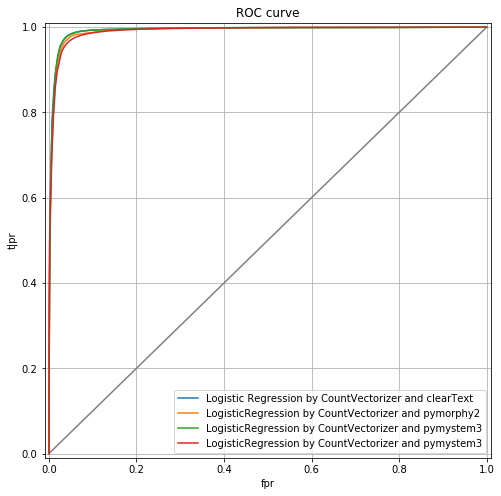

In [62]:
# Графики ROC_AUC для вычисления точности классификатора
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'grey')
plt.ylabel('t|pr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

print('ROC_AUC')

### clean text

fpr_LR_CV, tpr_LR_CV, thresholds = roc_curve(y_test, predict_proba_LR_CV[:,1])
plt.plot(fpr_LR_CV, tpr_LR_CV, label='Logistic Regression by CountVectorizer and clearText')
print('LogisticRegression clearText\t\t', roc_auc_score(y_test, predict_proba_LR_CV[:,1]))

### pymorphy2

fpr_LR_CV_morph, tpr_LR_CV_morph, thresholds = roc_curve(y_test, predict_proba_LR_CV_morph[:,1])
plt.plot(fpr_LR_CV_morph, tpr_LR_CV_morph, label='LogisticRegression by CountVectorizer and pymorphy2')
print('LogisticRegression pymurphy2\t\t', roc_auc_score(y_test, predict_proba_LR_CV_morph[:,1]))

### pymystem3

fpr_LR_CV_mystem, tpr_LR_CV_mystem, thresholds = roc_curve(y_test, predict_proba_LR_CV_mystem[:,1])
plt.plot(fpr_LR_CV_mystem, tpr_LR_CV_mystem, label='LogisticRegression by CountVectorizer and pymystem3')
print('LogisticRegression pymystem3\t\t', roc_auc_score(y_test, predict_proba_LR_CV_mystem[:,1]))

fpr_RFC_CV_mystem, tpr_RFC_CV_mystem, thresholds = roc_curve(y_test, predict_proba_RFC_CV_mystem[:,1])
plt.plot(fpr_RFC_CV_mystem, tpr_RFC_CV_mystem, label='LogisticRegression by CountVectorizer and pymystem3')
print('RandomForestClassifier pymystem3\t', roc_auc_score(y_test, predict_proba_RFC_CV_mystem[:,1]))

plt.legend()

#### Странно но лучший результат предсказания получается при чистом текте без морфоанализа?

### 4. Получение результата по лучшему алгоритму

In [57]:
%%time
result_predict = model_LR_CV.predict(df_test_preproc['text'])

df_result = pd.DataFrame(
    data = {
        'id':df_test_preproc['id'],
        'target':result_predict
    } 
)

print(df_result['target'].value_counts(), '\n')
print(df_result.info())

resFileName = 'result_'+ str(roc_auc_score_LR_CV).replace('.','_') +'.csv'
df_result.to_csv(resFileName, sep=',', encoding='utf-8', index=False)
print(resFileName)

os.system('say "Работа завершена!"')

0    89726
1    80453
Name: target, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170179 entries, 0 to 170178
Data columns (total 2 columns):
id        170179 non-null int64
target    170179 non-null int64
dtypes: int64(2)
memory usage: 2.6 MB
None
result_0_9925268139236129.csv
CPU times: user 1min 10s, sys: 5.93 s, total: 1min 16s
Wall time: 1min 25s
